# Mathematical Model Formulation using JijModeling and Optimization with OpenJij
In this tutorial, we explain the process of formulating a mathematical model using [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/), converting the mathematical model to QUBO, and solving it with OpenJij.

In [1]:
# !pip install jijmodeling ommx-openjij-adapter

In [9]:
import jijmodeling as jm
import numpy as np

# Traveling Salesman Problem (TSP)
We discuss the traveling salesman problem (TSP) as an example of a constrained optimization problem.
Suppose a salesman travels once to each of the  cities to sell a product and then returns to the city he started from.
The problem is to find the route with the shortest distance to reduce the cost of travel.

### Constraints
In this problem, there are two constraints: a location constraint, which states that a salesman can only visit each point once, and a time constraint, which states that since there is only one salesman, he can only be in one city at a given time.

Using a binary variable with $x_{t,i}=1$ when visiting the $i$th city at time $t$ and $x_{t,i}=0$ otherwise, the above two constraints are:


$$\text{Location constraint : }\sum_{t=1}^N x_{t,i}=1 \quad \forall i$$

$$\text{Time constraint : }\sum_{i=1}^N x_{t,i}=1 \quad \forall t$$

A one-hot constraint is a type of constraint in which one of the above variables is 1.

### Objective Function
TSP is a problem of finding the shortest route.
Therefore, if $d_{ij}$ is the distance between cities $i$ and $j$, the distance traveled when visiting city $i$ at time $t$ and city $j$ at time $t+1$ is:

$$d_{ij}x_{t,i}x_{t+1,j}$$

The sum of the above is:

$$\sum_{t=1}^N\sum_{i=1}^N \sum_{j=1}^N d_{ij}x_{t,i}x_{t+1,j}$$

This is the total distance traveled, which is the objective function we wish to minimize.

To perform Ising optimization as described in the previous tutorials, a mathematical model with such constraints must be converted to an Ising Hamiltonian or QUBO Hamiltonian.
Doing such work by hand is tedious and may cause bugs between the actual mathematical model and QUBO.
JijModeling can do all this work automatically.
In other words, it can code the mathematical model constructed as described above and automatically convert it to QUBO.
In this section, we explain how to use JijModeling to solve TSP.

## Building a Mathematical Model of the TSP using JijModeling
First, we use JijModeling to describe the mathematical model of the problem.
Unlike common modelers for mathematical optimization calculations, JijModeling builds the mathematical model independently from the data of the problem instance.
By constructing the mathematical model this way, the generality of the mathematical model can be ensured.
Moreover, mathematical equations can be described intuitively, just like writing mathematical equations on paper.
Furthermore, the mathematical model described in JijModeling can be checked in LaTeX on the notebook.

In this section, we construct mathematical models one by one with JijModeling.

First, let us define the variables and the constants of the problem.

In [10]:
dist = jm.Placeholder("dist", ndim=2)
N = jm.Placeholder("N")
x = jm.BinaryVar("x", shape=(N, N))
i = jm.Element("i", (0,N))
j = jm.Element("j", (0,N))
t = jm.Element("t", (0,N))

Here, `jm.Placeholder` represents a constant, which is the distance matrix and the number of cities.
By varying the distance matrix and number of cities data, we represent various sizes of TSP.

Binary variables are represented by `jm.Binary`.
Here we define a binary variable of $N\times N$.
Then, we use `jm.Element` to define the subscripts `i`,`j`,`t`.
These are used to represent the range of sums.

In JijModeling, we create a `jm.Problem` instance and add objective functions and constraints to it.
Next, we will define the objective function using the variables we have defined.

In [11]:
problem = jm.Problem("TSP")
obj = jm.sum([t, i, j], dist[i, j] * x[t, i] * x[(t + 1) % N, j])
problem += obj
problem

The sum can be expressed with `jm.Sum`.
The first argument of `jm.Sum` is the indices to be summed, and since the objective function of TSP takes sums for three indices, we pass those indices (`jm.element`) in a list.

Then, we add the constraint conditions.

In [12]:
# Constraint 1 : one-hot position constraint
problem += jm.Constraint(
            "one-hot location",
            jm.sum(t,x[t,i]) == 1,
            forall=i,
        )

# Constraint 2 : one-hot time constraint
problem += jm.Constraint(
            "one-hot time",
            x[t, :].sum() == 1,
            forall=t,
        )

Constraints can be expressed using `jm.Constraint`.
The first argument is the name of the constraint condition, and the second argument is a mathematical expression of the constraint condition.

This constraint has an optional argument, `forall`.
This is a JijModeling argument that expresses what is expressed in a mathematical model as "for any $i$" or "$\forall i$".

Finally, let us check the mathematical model we have just described.

In [13]:
problem

We see the same mathematical expression displayed as in the mathematical model used in the explanation.

This completes the construction of the mathematical model.
As above, JijModeling allows you to code mathematical models by comparing them with mathematical formulas.

## Creating the Problem Data
Now that we have a mathematical model of the problem, the next step is to create data for the problem.
Here we will solve a simple problem with 5 cities and random distances between cities.

(0.0, 1.0)

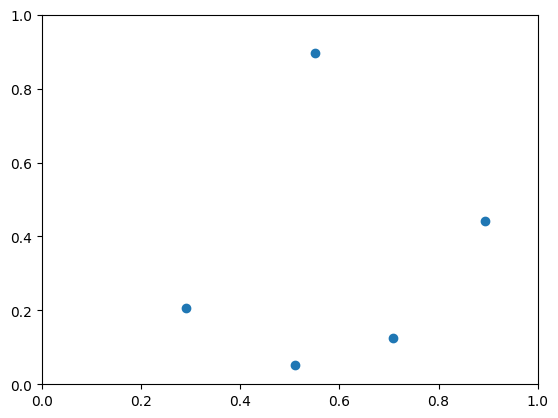

In [27]:
import matplotlib.pyplot as plt

inst_N = 5
np.random.seed(3)

x_pos = np.random.rand(inst_N) 
y_pos = np.random.rand(inst_N) 

plt.plot(x_pos, y_pos, 'o')
plt.xlim(0, 1)
plt.ylim(0, 1)

Since we assign the data to the `jm.Placeholder` to create the mathematical model, we need to pass the data in a dictionary type with the Placeholder's name as the key.
In this problem, we need to pass values for `N` and `dist`.

In [15]:
XX, XX_T = np.meshgrid(x_pos, x_pos)
YY, YY_T = np.meshgrid(y_pos, y_pos)
distance = np.sqrt((XX - XX_T)**2 + (YY - YY_T)**2)
instance_data = {
    "N":N,"dist": distance
}
instance_data

{'N': 5,
 'dist': array([[0.        , 0.7866063 , 0.73643374, 0.84577089, 0.56967619],
        [0.7866063 , 0.        , 0.4251585 , 0.21078131, 0.36540009],
        [0.73643374, 0.4251585 , 0.        , 0.26950348, 0.64576184],
        [0.84577089, 0.21078131, 0.26950348, 0.        , 0.54552992],
        [0.56967619, 0.36540009, 0.64576184, 0.54552992, 0.        ]])}

## Convert to OMMX-Instance

Now that we have prepared the mathematical model and data, we will create an OMMX Instance object by substituting the previously created `instance_data` into the model described in JijModeling.

`OMMX Instance` is an object that follows the data format representing mathematical model instances as specified by [OMMX](https://github.com/Jij-Inc/ommx), which is a common format for data exchange between modeler<>solver and modeler<>modeler in mathematical optimization. For more information about JijModeling and OMMX conversion, please refer to the [JijModeling documentation](https://jij-inc.github.io/JijModeling-Tutorials/en/introduction.html) or [OMMX documentation](https://jij-inc.github.io/ommx/en/introduction.html).

In [16]:
# Get interface to convert JijModeling objects to OMMX
interpreter = jm.Interpreter(instance_data)

# Get OMMX instance by plugging instance_data into problem
instance = interpreter.eval_problem(problem)

At this stage, `instance` is still data for constrained optimization. Let's check its contents briefly.

In [17]:
instance.decision_variables.head(5)

,kind,lower,upper,name,subscripts,description,substituted_value
id,,,,,,,
0,binary,0.0,1.0,x,"[0, 0]",<NA>,<NA>
1,binary,0.0,1.0,x,"[0, 1]",<NA>,<NA>
2,binary,0.0,1.0,x,"[0, 2]",<NA>,<NA>
3,binary,0.0,1.0,x,"[0, 3]",<NA>,<NA>
4,binary,0.0,1.0,x,"[0, 4]",<NA>,<NA>


In [18]:
instance.decision_variables.head(5)

,kind,lower,upper,name,subscripts,description,substituted_value
id,,,,,,,
0,binary,0.0,1.0,x,"[0, 0]",<NA>,<NA>
1,binary,0.0,1.0,x,"[0, 1]",<NA>,<NA>
2,binary,0.0,1.0,x,"[0, 2]",<NA>,<NA>
3,binary,0.0,1.0,x,"[0, 3]",<NA>,<NA>
4,binary,0.0,1.0,x,"[0, 4]",<NA>,<NA>


## Converting Instance to QUBO
We can confirm that binary variables and constraints have been successfully defined.
Next, let's convert the OMMX Instance to QUBO. OMMX Instance uses the penalty method for QUBO conversion.
Running `instance.to_qubo()` will perform the conversion to QUBO. For details about to_qubo, please refer to the [to_qubo API Reference](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.Instance.to_qubo). 

If you want to adjust the penalty coefficient weights, you can:
- Use `uniform_penalty_weight` to adjust all penalty coefficients uniformly
- Or specify `penalty_weights: dict[int, float]` using the Constraint table IDs as keys to individually adjust penalty coefficients for specific constraints

If not specified, all penalty coefficients will default to 1.0.

In [19]:
qubo, const = instance.to_qubo(uniform_penalty_weight=0.8)

We have successfully generated QUBO.

# Performing Optimization using OpenJij
Since QUBO has been obtained, optimization calculations can be performed as before using this QUBO.

In [21]:
import openjij as oj

In [22]:
sampler = oj.SASampler()
res = sampler.sample_qubo(Q=qubo, num_reads=100)

# Using ommx-openjij-adapter for Solution Analysis
Since running optimization with OpenJij returns a sequence of 0s and 1s, which is difficult to read. Let's use ommx-openjij-adapter to verify if the constraints are satisfied and convert the solution into a more usable format.

In [23]:
import ommx_openjij_adapter as oj_ad

# Adapter handles conversion between OMMX Instance and OpenJij
adapter = oj_ad.OMMXOpenJijSAAdapter(instance)

# Convert OpenJij results to OMMX SampleSet.
# At this point, it calculates the objective function of the original optimization problem and checks if constraints are satisfied.
sampleset = adapter.decode_to_sampleset(res)

`sampleset` is a format that contains multiple solutions. We will select the best solution from these.

The `.best_feasible` method selects the solution with the smallest objective function value among feasible solutions that satisfy the constraints in the instance. However, when using `instance.to_qubo`, all constraints are removed and combined into the objective function as penalties, so we cannot use this method to select feasible solutions.

The operation of removing constraints and combining them into the objective function as penalties is called relaxation. In other words, the `instance` has been relaxed by calling `.to_qubo`. However, we typically want to verify if the original constraints are satisfied. Even though the constraints appear to be removed after relaxation, they are actually preserved internally in a different location. Therefore, the `.best_feasible_unrelaxed` method is available to extract feasible solutions based on the pre-relaxation state. After converting to QUBO, we can use this method to select the solution with the best objective function value from among the feasible solutions.

In [24]:
best_sample = sampleset.best_feasible_unrelaxed()

`.extract_decision_variables` is a method that returns the OpenJij results converted back to the original mathematical model variables in an easy-to-read format.

In [25]:
x_value: dict[tuple[int, int], float] = best_sample.extract_decision_variables("x")
nonzero_keys = {k for k, v in x_value.items() if v > 0.5}
nonzero_keys

{(0, 1), (1, 4), (2, 0), (3, 2), (4, 3)}

You can check the original constraints and their values in `sampleset.constraints`. The `value` field contains the value of the left side minus the right side of the constraint equation. If the constraint is satisfied, it will be 0; if not satisfied, it will be 1 or greater. The `feasible` field contains a boolean value indicating whether this constraint is satisfied. Since we used `.best_feasible_unrelaxed`, we can confirm that all constraints are satisfied.

Additionally, `removed_reason` indicates that this constraint was combined into the objective function as a penalty using the `uniform_penalty_method`.

In [26]:
sampleset.constraints

,equality,used_ids,name,subscripts,description,removed_reason,value.0,value.1,value.2,value.3,...,feasible.41,feasible.27,feasible.95,feasible.69,feasible.51,feasible.32,feasible.1,feasible.4,feasible.25,feasible.47
id,,,,,,,,,,,,,,,,,,,,,
0,=0,"{0, 5, 10, 15, 20}",one-hot location,[0],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
1,=0,"{1, 6, 11, 16, 21}",one-hot location,[1],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
2,=0,"{2, 7, 12, 17, 22}",one-hot location,[2],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
3,=0,"{3, 8, 13, 18, 23}",one-hot location,[3],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
4,=0,"{4, 9, 14, 19, 24}",one-hot location,[4],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
5,=0,"{0, 1, 2, 3, 4}",one-hot time,[0],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
6,=0,"{5, 6, 7, 8, 9}",one-hot time,[1],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
7,=0,"{10, 11, 12, 13, 14}",one-hot time,[2],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True
8,=0,"{15, 16, 17, 18, 19}",one-hot time,[3],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True


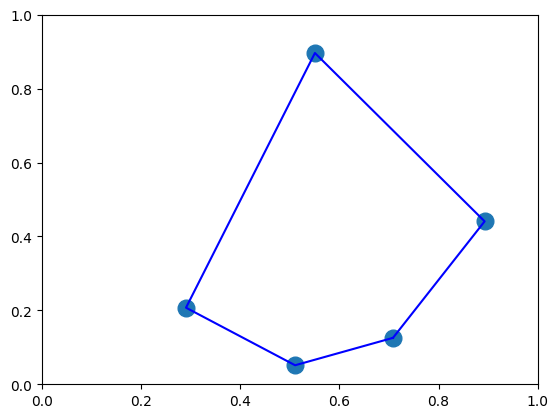

In [28]:
tour = [0 for _ in range(inst_N)]
for t, i in nonzero_keys:
    tour[t] = i
tour.append(tour[0])

plt.plot(x_pos, y_pos, "o", markersize=12)
plt.plot(x_pos[tour], y_pos[tour], "blue")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()